In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


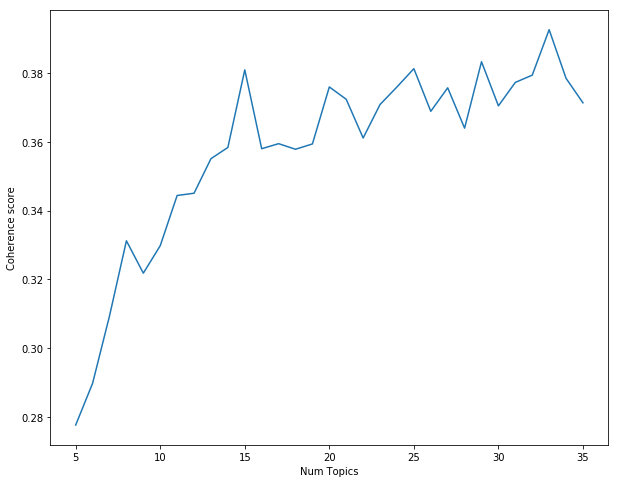

In [15]:
# Show graph
x = range(start, stop, step)
plt.figure(figsize=(10, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.277647   Model index 0
Num Topics = 6  has Coherence Value of 0.289777   Model index 1
Num Topics = 7  has Coherence Value of 0.309361   Model index 2
Num Topics = 8  has Coherence Value of 0.331218   Model index 3
Num Topics = 9  has Coherence Value of 0.321804   Model index 4
Num Topics = 10  has Coherence Value of 0.329784   Model index 5
Num Topics = 11  has Coherence Value of 0.344389   Model index 6
Num Topics = 12  has Coherence Value of 0.345041   Model index 7
Num Topics = 13  has Coherence Value of 0.355093   Model index 8
Num Topics = 14  has Coherence Value of 0.358352   Model index 9
Num Topics = 15  has Coherence Value of 0.380918   Model index 10
Num Topics = 16  has Coherence Value of 0.357988   Model index 11
Num Topics = 17  has Coherence Value of 0.359456   Model index 12
Num Topics = 18  has Coherence Value of 0.357831   Model index 13
Num Topics = 19  has Coherence Value of 0.359372   Model index 14
Num Topics = 20  has Cohe

In [17]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [20]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [21]:
len(bonus_words)

192

In [22]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [23]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [24]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
It was a clear, breezy day, and the grass rippled under their feet as they marched down the sloping lawns toward a  smooth, flat lawn on the opposite side of the grounds to the forbidden forest, whose trees were swaying darkly in the distance.
Harry caught sight of Malfoy, Crabbe, and Goyle's triumphant faces as he left, walking numbly in Professor McGonagall's wake as she strode toward the castle.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or wher

Aunt Petunia's high, false laugh sounded from the living room.
If the Dursleys hear anything, if they know you're here —" "Harry Potter asks if he can help Dobby .
There were screams from the dining room and Uncle Vernon  burst into the kitchen to find Harry, rigid with shock, covered from head to foot in Aunt Petunia's pudding.
Aunt Petunia was just passing around a box of after-dinner mints when a huge barn owl swooped through the dining room window, dropped a letter on Mrs. Mason's head, and swooped out again.
Yours sincerely, Mafalda Hopkirk improper use of magic office Ministry of Magic Harry looked up from the letter and gulped.

Chapter 3 - THE BURROW
"One good push —" Harry and George threw their shoulders against the trunk and it slid out of the window into the back seat of the car.
But the Weasleys gave a gigantic tug and Harry's leg slid out of Uncle Vernon's grasp — Harry was in the car — he'd slammed the door shut — "Put your foot down, Fred!"
Sending the family servant to

Snape prowled through the fumes, making waspish remarks about the Gryffindors' work while the Slytherins sniggered appreciatively.
As half the class lumbered up to Snape's desk, some weighted down with arms like clubs, others unable to talk through gigantic puffed-up lips, Harry saw Hermione slide back into the dungeon, the front of her robes bulging.
When everyone had taken a swig of antidote and the various swellings had subsided, Snape swept over to Goyle's cauldron and scooped out the twisted black remains of the firework.
"Dear, dear," said Lockhart, skittering through the crowd, looking at the aftermath of the duels.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Mandrakes to grow quickly and revive Mrs. Norris and Col

Far from wishing Harry a happy birthday, none of the Dursleys made any sign that they had noticed Harry enter the room, but Harry was far too used to this to care.
Even though she was not a blood relative of Harry's (whose mother had been Aunt Petunia's sister), he had been forced to call her "Aunt" all his life.
At Dudley's fifth birthday party, Aunt Marge had whacked Harry around the shins with her walking stick to stop him from beating Dudley at musical statues.
Harry knew perfectly well that Dudley only put up with Aunt Marge's hugs because he was well paid for it, and sure enough, when they broke apart, Dudley had a crisp twenty-pound note clutched in his fat fist.
Aunt Marge and Aunt Petunia kissed, or rather, Aunt Marge bumped her large jaw against Aunt Petunia's bony cheekbone.

Chapter 3 - THE KNIGHT BUS
A funny prickling on the back of his neck had made Harry feel he was being watched, but the street appeared to be deserted, and no lights shone from any of the large square ho

quo;S MAP Madam Pomfrey insisted on keeping Harry in the hospital wing for the rest of the weekend.
I chose a very inconvenient time to fall ill." What with the promise of anti-dementor lessons from Lupin, the thought that he might never have to hear his mother's death again, and the fact that Ravenclaw flattened Hufflepuff in their Quid-ditch match at the end of November, Harry's mood took a definite upturn.
He pulled out the map again and saw, 'S MAP to his astonishment, that a new ink figure had appeared upon it, labeled Harry Potter.
'S MAP Harry and Hermione made their way to the back of the room, where there was a small, vacant table between the window and a handsome Christmas tree, which stood next to the fireplace.
I was Junior Minister in the Department of Magical Catastrophes at the time, and I was one of the first on the scene after Black murdered all those people.

Chapter 11 - THE FIREBOLT
Harry didn't have a very clear idea of how he had managed to get back into the Honey

"I found this at the base of the Whomping Willow," said Snape, throwing the cloak aside, careful to keep this wand pointing directly at Lupin's chest.
"I've told the headmaster again and again that you're helping your old friend Black into the castle, Lupin, and here's the proof.
Perhaps the dementors will have a kiss for him too —" Before he knew what he was doing, Harry had crossed the room in three strides and blocked the door.
Then, before I could curse him, he blew apart the street with the wand behind his back, killed everyone within twenty feet of himself — and sped down into the sewer with the other rats.
Crookshanks leapt lightly off the bed and led the way out of the room, his bottlebrush tail held jauntily high.

Chapter 20 - THE DEMENTOR
The difference it made was startling, as though a person ten years younger were shining through the starved mask; for a moment, he was recognizable as the man who had laughed at Harry's parents' wedding.
The grounds were very dark now; the 

Harry disentangled himself from Ron and got to his feet.
"Well, why don't you, Harry, and Hermione go and get us some water then" — Mr. Weasley handed over the kettle and a couple of saucepans — "and the rest of us will get some wood for a fire?"
He's just started at the Ministry — and this is Fred — no, George, sorry — that's Fred — Bill, Charlie, Ron — my daughter, Ginny — and Ron's friends, Hermione Granger and Harry Potter."
Bagman did the smallest of double takes when he heard Harry's name, and his eyes performed the familiar flick upward to the scar on Harry's forehead.
"You don't want to go showing Mr. Bagman rubbish like that —" Percy hissed, but Bagman didn't seem to think the wand was rubbish at all; on the contrary, his boyish face shone with excitement as he took it from Fred, and when the wand gave a loud squawk and turned into a rubber chicken, Bagman roared with laughter.

Chapter 8 - THE QUIDDITCH WORLD CUP
The great shamrock dissolved, the leprechauns drifted down onto

"The way he talks," Harry muttered as he hobbled out of the Defense Against the Dark Arts class an hour later (Moody had insisted on putting Harry through his paces four times in a row, until Harry could throw off the curse entirely), "you'd think we were all going to be attacked any second."
During the following week, there seemed to be only one topic of conversation, no matter where Harry went: the Triwizard Tournament.
Rumors were flying from student to student like highly contagious germs: who was going to try for Hogwarts champion, what the tournament would involve, how the students from Beauxbatons and Durmstrang differed from themselves.
Then, checking that Fred and George were safely immersed in further discussions about the Triwizard Tournament, Harry read out Sirius's letter in a whisper to Ron and Hermione.
"Dear old Hogwarts," he said, looking up at the castle and smiling; his teeth were rather yellow, and Harry noticed that his smile did not extend to his eyes, which remai

The bell was due to ring at any moment, and Harry and Ron, who had been having a sword fight with a couple of Fred and George's fake wands at the back of the class, looked up, Ron holding a tin parrot and Harry, a rubber haddock.
On the whole, Harry had to admit that even with the embarrassing prospect of opening the ball before him, life had definitely improved since he had got through the first task.
He wasn't attracting nearly as much unpleasantness in the corridors anymore, whichCHAPTER TWENTY-TWO he suspected had a lot to do with Cedric — he had an idea Cedric might have told the Hufflepuffs to leave Harry alone, in gratitude for Harry's tip-off about the dragons.
"She didn' seem very int'rested in magical creatures, ter tell yeh the truth," Hagrid said, when Harry, Ron, and Hermione asked him how his interview with Rita Skeeter had gone during the last Care of Magical Creatures lesson of the term.
Some of the teachers, like little Professor Flitwick, gave up trying to teach them 

All three of them were so tired they could happily have put their heads down on the desks and slept; even Hermione wasn't taking her usual notes, but was sitting with her head on her hand, gazing at Professor Binns with her eyes out of focus.
When the bell finally rang, they hurried out into the corridors toward the Dark Arts classroom and found Professor Moody leaving it.
His magical eye followed a couple of passing first years, who sped up, looking nervous; it rolled into the back of Moody's head and watched them around the corner before he spoke again.CHAPTER TWENTY-NINE "Come in here."
Lower and lower they flew, the wind blowing pleasantly in Harry's face, until they reached a dark and broken window in the upper story of the house and entered.
He hurried through the gap in the walls and stepped onto the foot of a spiral stone staircase, which moved slowly upward as the doors closed behind him, taking him up to a polished oak door with a brass door knocker.

Chapter 30 - THE PENSIEV

As he spoke, visions of everything that had passed that night seemed to rise before his eyes; he saw the sparkling surface of the potion that had revived Voldemort; he saw the Death Eaters Apparating between the graves around them; he saw Cedric's body, lying on the ground beside the cup.
Harry described how the figures that had emerged from the wand had prowled the edges of the golden web, how Voldemort had seemed to fear them, how the shadow of Harry's father had told him what to do, how Cedric's had made its final request.
He transformed back into the great black dog and walked with Harry and Dumbledore out of the office, accompanying them down a flight of stairs to the hospital wing.
Everything around him became hazy; the lamps around the hospital wing seemed to be winking at him in a friendly way through the screen around his bed; his body felt as though it was sinking deeper into the warmth of the feather matress.
"If the magical community got wind that I had approached the giant

The door of the telephone box sprang open and Mr. Weasley stepped out of it, followed by Harry, whose mouth had fallen open.
Glittering jets of water were flying from the ends of the two wands, the point of the centaur's arrow, the tip of the goblin's hat, and each of the house-elf's ears, so that the tinkling hiss of falling water was added to the pops and cracks of Apparators and the clatter of footsteps as hundreds of witches and wizards, most of whom were wearing glum, early-morning looks, strode toward a set of golden gates at the far end of the hall.
The lift doors opened; Harry glimpsed an untidy-looking corridor, with various posters of Quidditch teams tacked lopsidedly on the walls; one of the wizards in the lift, who was carrying an armful of broomsticks, extricated himself with difficulty and disappeared down the corridor.
"Level five, Department of International Magical Cooperation, incorporating the International Magical Trading Standards Body, the International Magical Of

"Look, I don't think you should," said Hermione seriously, "you're both really behind on homework as it —" But she broke off; the morning post was arriving and, as usual, the Daily Prophet was soaring toward her in the beak of a screech owl, which landed perilously close to the sugar bowl and held out a leg; Hermione pushed a Knut into its leather pouch, took the newspaper, and scanned the front page critically as the owl took off again.
the usual rubbish," Hermione concluded, laying down her half of the paper and looking fearfully at Harry and Ron.
Sturgis Podmore, 38, of number two, Laburnum Gardens, Clapham, has appeared in front of the Wizengamot charged with trespass and attempted robbery at the Ministry of Magic on 31st August.
"Yeah, and Dumbledore said it happened whenever Voldemort was feeling a powerful emotion," said Harry, ignoring, as usual, Ron and Hermione's winces.
"I know her by reputation and I'm sure she's no Death Eater —" "She's foul enough to be one," said Harry d

Harry and Ron wanted to go with her, but their mountain of homework had reached an alarming height again, so they grudgingly remained in the common room, trying to ignore the gleeful shouts drifting up from the grounds outside, where students were enjoying themselves skating on the frozen lake, tobogganing, and worst of all, bewitching snowballs to zoom up to Gryffindor Tower and rap hard on the windows.
Harry glanced at Ron and Hermione, who sighed but nodded, and the three of them set off after Hagrid, leading the rest of the class.
They were called upon to supervise the decoration of the castle ("You try putting up tinsel when Peeves has got the other end and is trying to strangle you with it," said Ron), to watch over first and second years spending their break times inside because of the bitter cold ("And they're cheeky little snotrags, you know, we definitely weren't that rude when we were in first year," said Ron), and to patrol the corridors in shifts with Argus Filch, who susp

Everybody seemed aware, for instance, that Harry and Marietta were the only students to have witnessed the scene in Dumbledore's office, and as Marietta was now in the hospital wing, Harry found himself besieged with requests to give a firsthand account wherever he went.
Harry moved around behind Snape and read the heading of the examination paper: defense against the dark arts — ordinary wizarding level So Snape had to be fifteen or sixteen, around Harry's own age.
James's hair stuck up at the back exactly as Harry's did, his hands could have been Harry's, and Harry could tell that when James stood up, they would be within an inch of each other's heights.
Snape remained close by, still buried in his examination questions; but this was Snape's memory, and Harry was sure that if Snape chose to wander off in aCHAPTER TWENTY-EIGHT different direction once outside in the grounds, he, Harry, would not be able to follow James any farther.
What was making Harry feel so horrified and unhappy w

The door through which they had come was ajar straight ahead, Harry could see the glittering light of the bell jar, he pelted through it, the prophecy still clutched tight and safe in his hand, waited for the others to hurtle over the threshold before slamming the door behind them — "Colloportus!"
Both Harry's and the Death Eater's wands flew out of their hands and soared back toward the entrance to the Hall of Prophecy; both scrambled to their feet and charged after them, the Death Eater in front and Harry hot on his heels, Neville bringing up the rear, plainly horrorstruck at what he had done.
The cabinet fell to the floor and burst apart, glass flying everywhere, then sprang back up onto the wall, fully mended, then fell down again, and shattered — The Death Eater had snatched up his wand, which lay on the floor beside the glittering bell jar.
Harry expected to hear a clunk, for the man to hit solid glass and slide off the jar onto the floor, but instead, his head sank through the s

Harry and Dumbledore approached the back door of the Burrow, which was surrounded by the familiar litter of old Wellington boots and rusty cauldrons; Harry could hear the soft clucking of sleepy chickens coming from a distant shed.
Harry recognized it at once: It had nine hands, each inscribed with the name of a family member, and usually hung on the Weasleys' sitting room wall, though its current position suggested that Mrs. Weasley had taken to carrying it around the house with her.
They shook hands, and Mr. Weasley dropped into the chair beside Harry as Mrs. Weasley set a bowl of soup in front of him too.
Though a large vase of flowers had been placed on a desk in front of the small window, their perfume could not disguise the lingering smell of what Harry thought was gunpowder.
I mean, Tonks is okay-looking when she isn't doing stupid things to her hair and her nose, but —" "She's a damn sight nicer than Phlegm,'' said Ginny "And she's more intelligent, she's an Auror!"

Chapter 6 

Katie was removed to St. Mungo's Hospital for Magical Maladies and Injuries the following day, by which time the news that she had been cursed had spread all over the school, though the details were confused and nobody other than Harry, Ron, Hermione, and Leanne seemed to know that Katie herself had not been the intended target.
"You will remember, I am sure, that we left the tale of Lord Voldemort's beginnings at the point where the handsome Muggle, Tom Riddle, had abandoned his witch wife, Merope, and returned to his family home in Little Hangleton.
Harry bent over the Pensieve; his face broke the cool surface of the memory and then he was falling through darkness again.
And then" — Mrs. Cole took another swig of gin, slopping a little over her chin this time — "on the summer outing — we take them out, you know, once a year, to the countryside or to the seaside — well, Amy Benson and Dennis Bishop were never quite right afterwards, and all we ever got out of them was that they'd gone

The idea that Dumbledore valued his opinion this highly made Harry feel even more deeply ashamed that he had failed in the task of retrieving the Horcrux memory, and he shifted guiltily in his seat as Dumbledore raised the first of the two bottles to the light and examined it.
The house-elf returned within minutes, followed by a tall young man Harry had no difficulty whatsoever in recognizing as Voldemort.
She hooked the cup back off Voldemort's long forefinger and restored it gently to its box, too intent upon settling it carefully back into position to notice the shadow that crossed Voldemort's face as the cup was taken away.
"Time to leave, Harry," said Dumbledore quietly, and as the little elf bobbed away bearing the boxes, Dumbledore grasped Harry once again above the elbow and together they rose up through oblivion and back to Dumbledore's office.
Nevertheless, Harry felt the atmosphere in the room change subtly: Dumbledore's refusal to use Voldemort's chosen name was a refusal t

As they sped toward the castle, Harry glanced sideways at Dumbledore, ready to grab him should he fall, but the sight of the Dark Mark seemed to have acted upon Dumbledore like a stimulant: He was bent low over his broom, his eyes fixed upon the Mark, his long silver hair and beard flying behind him on the night air.
The Dark Mark was glittering directly above the Astronomy Tower, the highest of the castle.
"CHAPTER TWENTY-SEVEN Harry hurried over to the door leading to the spiral staircase, but his hand had only just closed upon the iron ring of the door when he heard running footsteps on the other side.
Harry's heart leapt: So these four had not eliminated all opposition, but merely broken through the fight to the top of the tower, and, by the sound of it, created a barrier behind them — "Now, Draco, quickly!"
Harry's heart was hammering so hard it seemed impossible that nobody could hear him standing there, imprisoned by Dumbledore's spell — if he could only move, he could aim a cur

Throwing aside the no longer glowing hairbrush, Harry stood up, swaying slightly, and saw Mrs. Weasley and Ginny running down the steps by the back door as Hagrid, who had also collapsed on landing, clambered laboriously to his feet.
As the lamplight fell across George's head, Ginny gasped and Harry's stomach lurched: One of George's ears was missing.
Harry explained briefly how the Death Eaters pursuing them had seemed to recognize him as the true Harry, how they had abandoned the chase, how they must have summoned Voldemort, who had appeared just before he and Hagrid had reached the sanctuary of Tonks's parents.
Glad of something to do, Harry pulled him free, then headed through the empty kitchen and back into the sitting room, where Mrs. Weasley and Ginny were still tending to George.
Mrs. Weasley had staunched his bleeding now, and by the lamplight Harry saw a clean, gaping hole where George's ear had been.

Chapter 6 - THE GHOUL IN PAJAMAS
The shock of losing Mad-Eye hung over the

The usual low whisper of "Severus Snape?"
"'Severus Snape, long-standing Potions master at Hogwarts School of Witchcraft and Wizardry, was today appointed headmaster in the most important of several staffing changes at the ancient school.
Snape, headmaster!
They won't accept Snape as headmaster.
The painted image of Phineas Nigellus Black was able to flit between his portrait in Grimmauld Place and the one that hung in the headmaster's office at Hogwarts: the circular tower-top room where Snape was no doubt sitting right now, in triumphant possession of Dumbledore's collection of delicate, silver magical instruments, the stone Pensieve, the Sorting Hat and, unless it had been moved elsewhere, the sword of Gryffindor.

Chapter 13 - THE MUGGLE-BORN REGISTRATION COMMISSION
As he passed gleaming wooden door after gleaming wooden door, each bearing a small plaque with the owner's name and occupation upon it, the might of the Ministry, its complexity, its impenetrability, seemed to force its

"I want to go and see Xenophilius Lovegood."
"Xenophilius Lovegood.
"It won't be like Godric's Hollow," Ron added, "Lovegood's on your side, Harry, The Quibbler's been for you all along, it keeps telling everyone they've got to help you!"
"Only, once we've seen Lovegood, let's try and look for some more Horcruxes, shall we?
"The Crumple-Horned Snorkack," said Xenophilius very clearly, a mulish look upon his face, "is a shy and highly magical creature, and its horn —" "Mr. Lovegood, I recognize the grooved markings around the base, that's an Erumpent horn and it's incredibly dangerous — I don't know where you got it —" "I bought it," said Xenophilius dogmatically, "two weeks ago, from a delightful young wizard who knew of my interest in the exquisite Snorkack.

Chapter 21 - THE TALE OF THE THREE BROTHERS
So Death picked up a stone from the riverbank and gave it to the second brother, and told him that the stone would have the power to bring back the dead.CHAPTER TWENTY-ONE "'And then De

"There's no chance of getting through any of them now, not with curses over the entrances and Death Eaters and dementors waiting at the exits."
Multicolored hammocks were strung from the ceiling and from a balcony that ran around the dark wood-paneled and windowless walls, which were covered in bright tapestry hangings: Harry saw the gold Gryffindor lion, emblazoned on scarlet; the black badger of Hufflepuff, set against yellow; and the bronze eagle of Ravenclaw, on blue.
As he turned his back hastily on the curious and delighted faces, the Room of Requirement vanished, and he was standing inside a ruined stone shack, and the rotting floorboards were ripped apart at his feet, a disinterred golden box lay open and empty beside the hole, and Voldemort's scream of fury vibrated inside his head.
They were standing in a dark corridor: Harry pulled Luna back into the shadows, fumbled in the pouch around his neck, and took out the Marauder's Map.
The sloping-shouldered figure of Alecto Carrow

A long time later, or maybe no time at all, it came to him that he must exist, must be more than disembodied thought, because he was lying, definitely lying, on some surface.
"But if Voldemort used the Killing Curse," Harry started again, "and nobody died for me this time — how can I be alive?"
But my guesses have usually been good," said Dumbledore happily, and they sat in silence for what seemed like a long time, while the creature behind them continued to whimper and tremble.
though a good one, I am sure," Dumbledore finished kindly.CHAPTER THIRTY-FIVE Harry sat in thought for a long time, or perhaps seconds.
For the first time since Harry had met Dumbledore, he looked'S CROSS less than an old man, much less.


